## initialization

### Load libraries

In [1]:
# Enable automiatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import findspark
findspark.init()

import sys
sys.path.append('./lib')
from import_modules import import_modules,modules
import_modules(modules)

from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions
from recon_plot import recon_plot
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter

    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.0 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


### Start Spark

In [5]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [7]:
import pyspark.sql

### Read information about stations

In [8]:
# read information about the stations
import pickle
Data_dir='../../Data/Weather'
stations=pickle.load(open(Data_dir+'/stations.pkl','r'))
stations.head()

,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


### Read Statistics File for region

In [9]:
data_dir='../../Data/Weather'
file_index='BBBSBBBB'

In [10]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


### Read time series information for region

In [11]:
data_dir+'/decon_'+file_index+'.parquet'

'../../Data/Weather/decon_BBBSBBBB.parquet'

In [12]:
df=sqlContext.read.parquet(data_dir+'/decon_'+file_index+'.parquet')
df.show(1)

+-------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|          coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|-350.48063244167156|-507.43573845549463|796.8032180365927|      9.1|BBBSBBBB| 42.5333| -70.8667|       SNWD|0.9007007129008506|0.6869409921253996|0.1334279056375058|0.7230709625993117|USC00197124|1620030.0|    31|[58 5A 58 5A 58 5...|1957.0|
+-------------------+-------

## Extract longitude/latitude information

We now extract information about the locations of the stations in our region and the number of measurements from each station.

#### The "aggregate" function

The command `agg` aggregates (reduces) a subset of the columns by applying one of the functions: `avg, max, min, sum, count`

It is typically applied after `groupBy('column')` which partitions the rows into groups.

The version we are using here: `df.agg()` is equivalent to `df.groupBy().agg()` which means: "group by nothing"

For more information look [here](http://spark.apache.org/docs/2.0.0/api/python/pyspark.sql.html#pyspark.sql.GroupedData.agg)

In [13]:
min_vals=df.agg({"longitude": "min", 'latitude':'min'}).collect()[0]
max_vals=df.agg({"longitude": "max", 'latitude':'max'}).collect()[0]
min_lat=min_vals['min(latitude)']
min_long=min_vals['min(longitude)']
max_lat=max_vals['max(latitude)']
max_long=max_vals['max(longitude)']
min_lat,max_lat,min_long,max_long

(42.1103, 42.6167, -72.6, -70.8)

## Extract information by station

An elternative syntax for aggregation is `df.groupBy('cols').mean()`

which performs a "mean" operation on all of the columns other than the grouped ones

In [14]:
agg_by_station = df.groupBy('station')
count_by_station=agg_by_station.count()
mean_by_station=agg_by_station.mean()
stat_by_station=mean_by_station.join(count_by_station,on='station')
pandas_by_station=stat_by_station.toPandas()

In [15]:
print pandas_by_station.shape
pandas_by_station.head(5)

(61, 15)


,station,avg(coeff_1),avg(coeff_2),avg(coeff_3),avg(elevation),avg(latitude),avg(longitude),avg(res_1),avg(res_2),avg(res_3),avg(res_mean),avg(total_var),avg(undefs),avg(year),count
0,USC00193624,-132.563397,-50.634007,-37.026185,10.7,42.2269,-70.9125,0.653419,0.503938,0.409200,2.930802,1.972217e+06,1.846154,1986.500000,52
1,USC00192806,82.699359,-39.723389,42.506575,100.9,42.5500,-71.7500,0.698150,0.535114,0.486943,1.049418,2.925373e+06,20.125000,1964.750000,8
2,USC00194580,-194.440734,-176.371607,-10.410520,62.5,42.4292,-71.4425,0.780525,0.625184,0.575384,0.843346,1.751388e+06,12.200000,2008.000000,5
3,USC00194744,-217.939395,82.376607,5.124254,27.4,42.5947,-71.0208,0.653598,0.530678,0.447212,2.348039,2.116999e+06,14.792453,1980.056604,53
4,USW00014753,34.735434,17.708040,10.062487,190.5,42.2122,-71.1136,0.716074,0.568716,0.485018,1.567945,3.007199e+06,0.265625,1980.500000,64


In [16]:
lat=np.array(pandas_by_station['avg(latitude)'])
longit=np.array(pandas_by_station['avg(longitude)'])
count=np.array(pandas_by_station['count'])
coeff_1 = np.array(pandas_by_station['avg(coeff_1)'])

In [17]:
def printout(L,k=4):
    for l in L:
        print l, 
        V=globals()[l]
        print '\ttype=,',type(V),
        print '\tlength=',len(V),
        print '\tfirst',k,'items:',V[:k]

In [18]:
printout(['coeff_1','longit','lat','count'])

coeff_1 	type=, <type 'numpy.ndarray'> 	length= 61 	first 4 items: [-132.56339669   82.69935936 -194.44073395 -217.9393948 ]
longit 	type=, <type 'numpy.ndarray'> 	length= 61 	first 4 items: [-70.9125 -71.75   -71.4425 -71.0208]
lat 	type=, <type 'numpy.ndarray'> 	length= 61 	first 4 items: [ 42.2269  42.55    42.4292  42.5947]
count 	type=, <type 'numpy.ndarray'> 	length= 61 	first 4 items: [52  8  5 53]


### Plot basic maps
Here we will plot maps that show us where the stations are located and how many sequences are associated with each


#### Basemap

* Basemap is a library for drawing maps and placing annotations on the maps.

  * To install basemap on your computer follow [these directions](https://github.com/matplotlib/basemap)
    * The `geos` package stores graphical information about countries, counties, coastlines, rivers etc. You might need to build that package that can take 10-30 minutes.
  * [BaseMap Documentation](http://matplotlib.org/basemap/)
* In order to plot in 2D a representation of the world, which is a ball in 3D, we need to use a **projection**. 
  * Basemap supports [many types of projections](http://matplotlib.org/basemap/users/mapsetup.html). For explanations see  [Wikipedia](http://en.wikipedia.org/wiki/Map_projection)
  * In this notebook we use the **Mercator projection** expained [here](http://matplotlib.org/basemap/users/merc.html)


In [19]:
from mpl_toolkits.basemap import Basemap

In [20]:
def plot_region(llcrnrlat=24,urcrnrlat=50,llcrnrlon=-125,urcrnrlon=-65,figsize=(15,10),resolution='i'):
    # resolution Can be c (crude), l (low), i (intermediate), h (high), f (full) or None
    # llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
    # are the lat/lon values of the lower left and upper right corners
    # of the map.
    # lat_ts is the latitude of true scale.
    # resolution = 'i' means use intermediate resolution coastlines.
    plt.figure(figsize=figsize)
    m = Basemap(llcrnrlat=llcrnrlat,urcrnrlat=urcrnrlat,\
                llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,lat_ts=20,resolution=resolution)
    m.drawcoastlines()
    m.fillcontinents(color='coral',lake_color='aqua')
    m.drawcountries(linewidth=2)
    m.drawstates(linewidth=1,color='blue')
    #m.drawrivers()
    return m

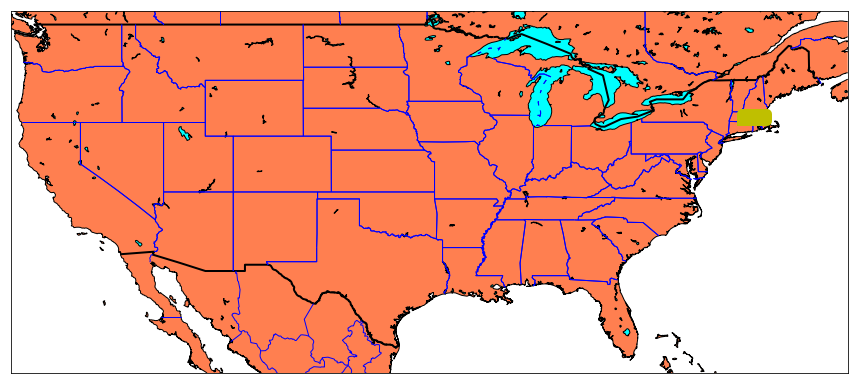

In [21]:
m = plot_region()
region_long=[min_long,max_long,max_long,min_long,min_long]
region_lat=[min_lat,min_lat,max_lat,max_lat,min_lat]
m.plot(region_long,region_lat,'y',latlon=True,lw=10)
plt.show()


* In this notebook we use `pyplot.scatter`, for more details, see 
  * [documentation in matplotlib](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)
  * [specialized documentation in basemap](http://matplotlib.org/basemap/api/basemap_api.html?highlight=scatter#mpl_toolkits.basemap.Basemap.scatter)


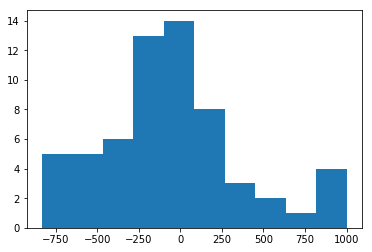

In [23]:
# log scale coeff_1
coeff_1 = np.array(pandas_by_station['avg(coeff_1)'])
#coeff_1=max(min(coeff_1,2000),-200)
#coeff_1=log(coeff_1-min(coeff_1)+1)
coeff_1[coeff_1>1000]=1000
#coeff_1
hist(coeff_1);

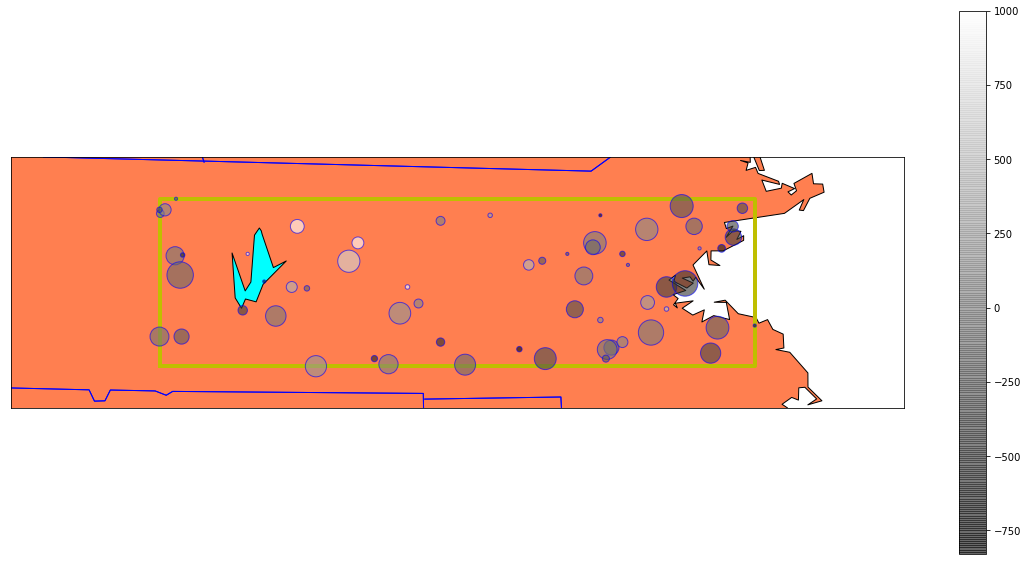

In [24]:
lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
m = plot_region(llcrnrlat=min_lat-lat_margin,urcrnrlat=max_lat+lat_margin,llcrnrlon=min_long-long_margin,urcrnrlon=max_long+long_margin,figsize=(20,10))
# m.etopo()  #ran into problems installing PIL to make this run
region_long=[min_long,max_long,max_long,min_long,min_long]
region_lat=[min_lat,min_lat,max_lat,max_lat,min_lat]
m.plot(region_long,region_lat,'y',latlon=True,lw=4)
m.scatter(longit,lat,s=count*10,c=coeff_1,marker='o',edgecolors='b',zorder=10,alpha=0.6,cmap=plt.get_cmap('gray')) # 
colorbar()
plt.show()

In [25]:
len(c1)

NameError: name 'c1' is not defined

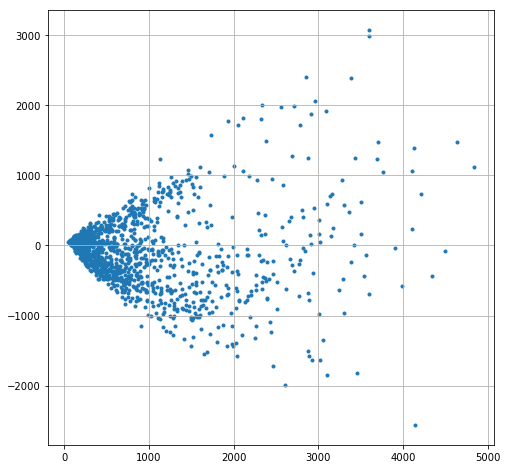

In [26]:
coeffs=df.select('coeff_1','coeff_2','coeff_3').collect()
c1=np.array([row['coeff_1']+900 for row in coeffs])
c2=np.array([row['coeff_2']-100 for row in coeffs])
figure(figsize=(8,8))
plt.scatter(c1,c2,marker='.')

grid()

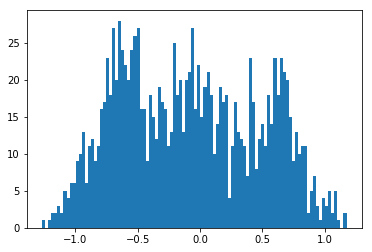

In [27]:
c2_normalize=c2/c1
hist(c2_normalize,bins=100);

In [28]:
df=df.withColumn('normalized coeff2',(df.coeff_2-100)/(df.coeff_1+900))
df.show(2)

+-------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+--------------------+
|            coeff_1|            coeff_2|          coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|   normalized coeff2|
+-------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+--------------------+
|-350.48063244167156|-507.43573845549463|796.8032180365927|      9.1|BBBSBBBB| 42.5333| -70.8667|       SNWD|0.9007007129008506|0.6869409921253996|0.1334279056375058|0.7230709625993117|USC00197124|1620030.0| 

In [29]:
df.columns

['coeff_1',
 'coeff_2',
 'coeff_3',
 'elevation',
 'label',
 'latitude',
 'longitude',
 'measurement',
 'res_1',
 'res_2',
 'res_3',
 'res_mean',
 'station',
 'total_var',
 'undefs',
 'vector',
 'year',
 'normalized coeff2']

In [30]:
cols=['coeff_1',
 'coeff_2',
 'coeff_3',
 'elevation',
 'latitude',
 'longitude',
 'res_1',
 'res_2',
 'res_3',
 'res_mean',
 'station',
 'total_var',
 'year',
 'normalized coeff2']

pandas_df=df.select(cols).toPandas()
pandas_df.head(2)

,coeff_1,coeff_2,coeff_3,elevation,latitude,longitude,res_1,res_2,res_3,res_mean,station,total_var,year,normalized coeff2
0,-350.480632,-507.435738,796.803218,9.1,42.5333,-70.8667,0.900701,0.686941,0.133428,0.723071,USC00197124,1620030.0,1957.0,-1.105395
1,1607.320458,-802.792722,1.949657,43.3,42.3861,-72.5375,0.306336,0.133294,0.133293,0.498957,USC00190120,7464358.0,1971.0,-0.360063


In [31]:
#df.pivot(index='foo', columns='bar', values='baz')
after1980=pandas_df[pandas_df['year']>1980]
year_station_coeff2_table=after1980.pivot(index='station',columns='year',values='normalized coeff2')

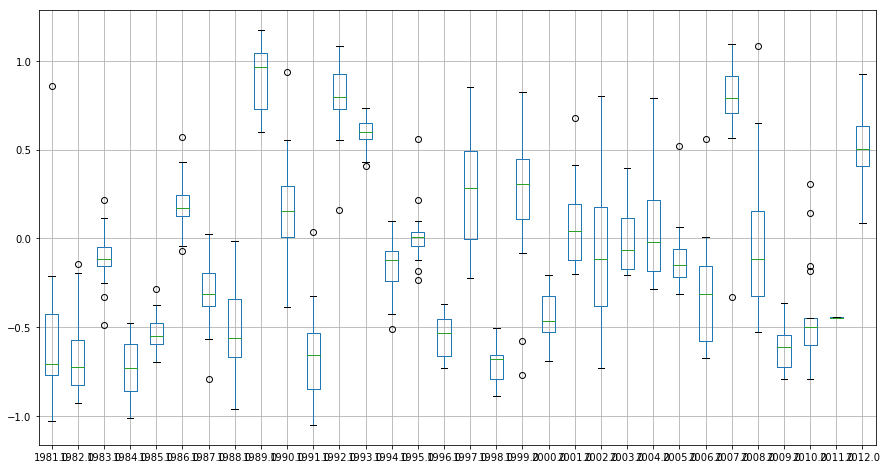

In [32]:
figure(figsize=(15,8))
year_station_coeff2_table.boxplot()

### How much of the variance can be explained by the year?

In [33]:
mean_coeff_by={}
std_coeff_by={}
for group_feature in ['year','station']:
    mean_coeff_by[group_feature]=after1980[[group_feature,'coeff_1','coeff_2','coeff_3']].groupby(group_feature).mean()
    std_coeff_by[group_feature]=after1980[[group_feature,'coeff_1','coeff_2','coeff_3']].groupby(group_feature).std()

In [34]:

mean_coeff_by['station']['coeff_1']

station
USC00190120   -165.810439
USC00190408    199.370779
USC00190535     -9.220713
USC00190562   -502.266330
USC00190593   -289.521323
USC00190998   -242.904592
USC00192107     -7.549726
USC00193229     -8.975487
USC00193401    442.245920
USC00193402   -117.989159
USC00193624   -254.197593
USC00193702   -156.566841
USC00193890   -330.293612
USC00194154   -538.508819
USC00194502   -364.488513
USC00194580   -194.440734
USC00194744   -422.845010
USC00194760   -813.754170
USC00195175   -236.072986
USC00195524   -264.690049
USC00196245   -210.127818
USC00196322    791.033262
USC00196783    -33.441623
USC00198278     54.783693
USC00198757    -60.153848
USC00198793    -26.527026
USC00199316   -402.151956
USW00014739   -556.126620
USW00014753    -40.309438
USW00014790   -430.110977
USW00094746   -223.039334
Name: coeff_1, dtype: float64

TypeError: unsupported operand type(s) for *: 'function' and 'int'

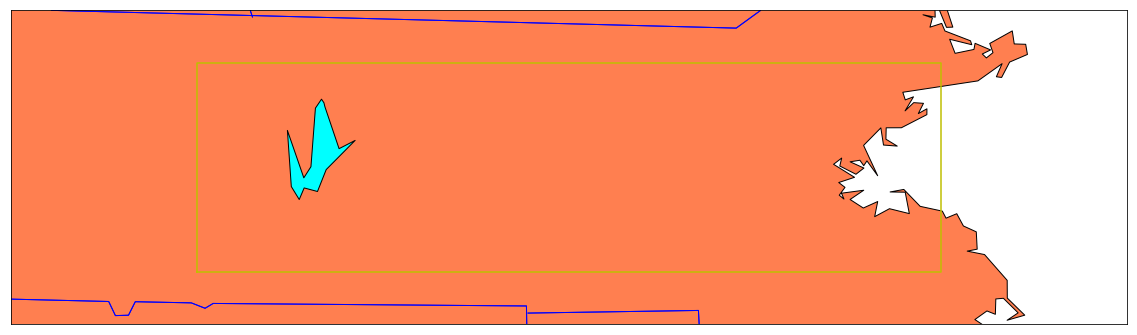

In [36]:
lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
c1=mean_coeff_by['station']['coeff_1']
#print len(longit),len(lat),len(size),len(c1)
#mn=min(c1);mx=max(c1)
#c1=(c1-mn)/(mx-mn)
m = plot_region(llcrnrlat=min_lat-lat_margin,urcrnrlat=max_lat+lat_margin,llcrnrlon=min_long-long_margin,urcrnrlon=max_long+long_margin,figsize=(20,10))
# m.etopo()  #ran into problems installing PIL to make this run
region_long=[min_long,max_long,max_long,min_long,min_long]
region_lat=[min_lat,min_lat,max_lat,max_lat,min_lat]
m.plot(region_long,region_lat,'y',latlon=True)
#m.scatter(longit,lat,marker='o',c='g',latlon=True)   #,size,c='g') 
m.scatter(longit,lat,s=size*10,c=list(c1),marker='o',edgecolors='b',zorder=10,alpha=0.6) # 
#colorbar()
plt.show()

### There seems to be 3 separate populations
One around -7. another close to 0, and the third close to 0.6

Recall that this corresponds to whether the snow arrive mostly late, mostly early, or is distributed throughout the winter.

We would like to know whether this corresponds to year-to-year variations or whether it varies with region (or both).

NameError: name 'lons' is not defined

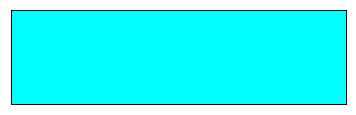

In [16]:
# draw parallels and meridians.
parallels = np.arange(-80,81,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])

#m.drawparallels(np.arange(-90.,91.,30.))
#m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')
# draw map with markers for locations
x, y = m(lons,lats)
z=x*0+40.
print shape(x),shape(y),shape(z)
m.scatter(x,y,2,z,cmap=plt.cm.jet,marker='o',edgecolors='none',zorder=10) 
#m.plot(x,y,'.g')
plt.title('weather stations')
plt.show()

In [ ]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'i' means use intermediate resolution coastlines.
plt.figure(figsize=(20,20),dpi=300)
m = Basemap(llcrnrlat=24,urcrnrlat=50,\
            llcrnrlon=-125,urcrnrlon=-65,lat_ts=20,resolution='i')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawcountries(linewidth=2)
m.drawstates(linewidth=1,color='blue')
#m.drawcounties()
#m.drawrivers()
plt.show()

In [ ]:
# draw parallels and meridians.
parallels = np.arange(-80,81,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])

#m.drawparallels(np.arange(-90.,91.,30.))
#m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')
# draw map with markers for locations
x, y = m(lons,lats)
z=np.array(elev)*99
print np.shape(x),np.shape(y),np.shape(z)
m.scatter(x,y,30,z,cmap=plt.cm.jet,marker='o',edgecolors='none',zorder=10) 
#m.plot(x,y,'.g')
plt.title('weather stations')
plt.show()

In [ ]:
hist(elev,bins=20);